In [1]:
import pandas as pd
import numpy as np
import autogluon.timeseries as agts
import time
import tqdm
import seaborn as sns
import polars as pl
from datetime import timedelta
import catboost

In [7]:
sub = pd.read_csv('4cast/submissions/sub0.csv')
sub['predict'] = np.log1p(sub['predict']) * 1.05
sub.to_csv('4cast/submissions/best_sub_mul_1_05.csv', index=False)

In [5]:
sub = pd.read_csv('4cast/submissions/sub0.csv')
sub['predict'] = sub['predict'] * 1.035
sub.to_csv('4cast/submissions/best_sub_mul_1_35.csv', index=False)

In [8]:
sub = pd.read_csv('4cast/submissions/sub0.csv')
sub1 = pd.read_csv('4cast/submissions/best_sub_mul_1_35.csv')

sub['predict'] = (sub['predict'] + sub1['predict']) / 2

sub.to_csv('4cast/submissions/best_sub_blend_1_035__50-50.csv', index=False)

In [14]:
import requests
from datetime import datetime

def get_usd_rub_rate(date):
    # Форматируем дату в формате, который принимает API ЦБ РФ
    formatted_date = date.strftime('%d/%m/%Y')
    
    # URL API ЦБ РФ для получения курса валют на конкретную дату
    url = f'https://www.cbr.ru/scripts/XML_daily.asp?date_req={formatted_date}'
    
    # Отправляем GET-запрос
    response = requests.get(url)
    
    # Проверяем статус ответа
    if response.status_code == 200:
        # Парсим XML-ответ
        from xml.etree import ElementTree as ET
        root = ET.fromstring(response.content)
        
        # Ищем курс доллара США (код R01235)
        for child in root.findall('Valute'):
            if child.find('CharCode').text == 'USD':
                rate = child.find('Value').text
                return float(rate.replace(',', '.'))
    else:
        print(f"Ошибка при запросе: {response.status_code}")
        return None

usd_rate = get_usd_rub_rate(calendar.loc[calendar['week'] == 110, 'date'].item())
if usd_rate:
    print(f"Курс доллара на {calendar.loc[calendar['week'] == 110, 'date'].item()}: {usd_rate} руб.")
else:
    print("Не удалось получить курс.")

Курс доллара на 2024-09-02 00:00:00: 91.1868 руб.


In [20]:
usd_prices = []
for date in tqdm(calendar['date']):
    usd_prices.append(get_usd_rub_rate(date))
    time.sleep(3)

  0%|          | 0/118 [00:00<?, ?it/s]

In [21]:
usd_prices

[57.3917,
 61.3101,
 60.3696,
 60.8993,
 59.1321,
 60.0924,
 60.3713,
 60.4696,
 60.0316,
 58.1006,
 55.2987,
 61.2475,
 63.0558,
 61.1958,
 61.5343,
 62.0955,
 60.2179,
 60.3741,
 60.4797,
 61.7749,
 62.3813,
 64.6078,
 68.676,
 70.3375,
 70.3375,
 67.5744,
 68.6656,
 69.3372,
 70.3847,
 72.7923,
 74.7588,
 74.7087,
 75.4592,
 75.9406,
 76.6044,
 76.4479,
 77.3233,
 82.3988,
 81.5045,
 81.4863,
 80.5093,
 76.8207,
 77.2041,
 79.9093,
 79.9667,
 80.8756,
 82.6417,
 83.6498,
 84.0793,
 88.3844,
 91.6879,
 90.119,
 90.3846,
 90.9783,
 94.8076,
 98.2066,
 93.4047,
 94.7117,
 96.3411,
 97.9241,
 96.6338,
 96.0419,
 97.4147,
 100.4911,
 97.3075,
 95.9053,
 93.2174,
 93.0351,
 92.0535,
 89.1237,
 88.8133,
 89.7619,
 91.6402,
 89.6966,
 91.9389,
 89.6883,
 89.6883,
 88.1324,
 88.5896,
 89.5159,
 90.6626,
 90.8901,
 92.5492,
 92.7519,
 91.3336,
 90.7493,
 91.87,
 92.6118,
 92.366,
 92.4155,
 93.4419,
 93.4409,
 91.7791,
 91.6918,
 91.8239,
 90.9873,
 89.7026,
 90.1915,
 88.7606,
 89.0658,
 87.

In [2]:
train = pd.read_parquet('4cast/target_series.parquet')
calendar = pd.read_csv('4cast/calendar.csv')
profiles = pd.read_parquet('4cast/profiles.parquet')

In [3]:
profiles

,inn_id,report_date,ipul,id_region,main_okved_group,diff_datopen_report_date_flg
0,inn10,2023-10-01,ip,45,47,3_6m
1,inn100,2023-10-01,ul,80,86,more_12y
2,inn1000006,2023-10-01,ip,86,49,more_12y
3,inn1000007,2023-10-01,ul,46,46,4_8y
4,inn1000008,2023-10-01,ip,None,None,NULL
...,...,...,...,...,...,...
32219181,inn99999,2024-08-01,ip,57,75,2_4y
32219182,inn999991,2024-08-01,ip,80,74,1_2y
32219183,inn999994,2024-08-01,ul,45,41,2_4y
32219184,inn999997,2024-08-01,ip,46,85,2_4y


In [4]:
profiles['inn_id'].nunique()

3069853

In [5]:
train['inn_id'].nunique()

51963

In [3]:
all_inn = list(set(train['inn_id']) & set(profiles['inn_id']))

In [37]:
profiles.loc[profiles['inn_id'].isin(all_inn), 'inn_id'].value_counts()

inn_id
inn1000051    11
inn4155186    11
inn4154503    11
inn4154660    11
inn4154692    11
              ..
inn2740253     9
inn288252      9
inn2506495     7
inn3688416     7
inn1012513     5
Name: count, Length: 51963, dtype: int64

In [3]:
sub = pd.read_csv('4cast/sample_submit.csv')

In [4]:
test = sub.copy()
test

,inn_id,week,predict
0,inn1000051,106,7.430786e+06
1,inn1000051,107,7.430786e+06
2,inn1000051,108,7.430786e+06
3,inn1000051,109,7.430786e+06
4,inn1000051,110,7.430786e+06
...,...,...,...
623551,inn999886,113,1.977608e+07
623552,inn999886,114,1.977608e+07
623553,inn999886,115,1.977608e+07
623554,inn999886,116,1.977608e+07


In [5]:
train['inn_id'].value_counts()

inn_id
inn1000051    106
inn4155408    106
inn4154818    106
inn4154866    106
inn4154898    106
             ... 
inn2586588    106
inn2586637    106
inn2586904    106
inn2586962    106
inn999886     106
Name: count, Length: 51963, dtype: int64

In [5]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [6]:
profiles['report_date'] = pd.to_datetime(profiles['report_date'])

In [22]:
calendar['usd'] = usd_prices

In [7]:
train = train.merge(calendar.drop_duplicates(subset='week').reset_index(drop=True)[['week', 'date']], on='week', how='left')

In [8]:
profiles = profiles.rename(columns={'report_date': 'date'}).merge(calendar[['week', 'date']], on='date', how='left')
profiles

,inn_id,date,ipul,id_region,main_okved_group,diff_datopen_report_date_flg,week
0,inn10,2023-10-01,ip,45,47,3_6m,61
1,inn100,2023-10-01,ul,80,86,more_12y,61
2,inn1000006,2023-10-01,ip,86,49,more_12y,61
3,inn1000007,2023-10-01,ul,46,46,4_8y,61
4,inn1000008,2023-10-01,ip,None,None,NULL,61
...,...,...,...,...,...,...,...
32219181,inn99999,2024-08-01,ip,57,75,2_4y,105
32219182,inn999991,2024-08-01,ip,80,74,1_2y,105
32219183,inn999994,2024-08-01,ul,45,41,2_4y,105
32219184,inn999997,2024-08-01,ip,46,85,2_4y,105


In [20]:
profiles.describe()

,date,week
count,32219186,3.221919e+07
mean,2024-03-04 20:32:24.548828160,8.374817e+01
min,2023-10-01 00:00:00,6.100000e+01
25%,2023-12-01 00:00:00,7.000000e+01
50%,2024-03-01 00:00:00,8.300000e+01
75%,2024-06-01 00:00:00,9.600000e+01
max,2024-08-01 00:00:00,1.050000e+02
std,NaN,1.380417e+01


In [14]:
train['week'].min()

0

In [9]:
def date_cluster(df):
    df['date_cluster'] = -1
    df.loc[df['week'].isin(range(71)), 'date_cluster'] = '0'
    df.loc[df['week'].isin(range(71, 84)), 'date_cluster'] = '1'
    df.loc[df['week'].isin(range(84, 97)), 'date_cluster'] = '2'
    df.loc[df['week'].isin(range(97, 106)), 'date_cluster'] = '3'
    return df

train = date_cluster(train)

/tmp/ipykernel_33462/1871917756.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['week'].isin(range(71)), 'date_cluster'] = '0'


In [24]:
train['date_cluster'].value_counts(dropna=False)

date_cluster
0    3689373
1     675519
2     675519
3     467667
Name: count, dtype: int64

In [10]:
profiles = date_cluster(profiles)

/tmp/ipykernel_33462/1871917756.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['week'].isin(range(71)), 'date_cluster'] = '0'


In [26]:
profiles

,inn_id,date,ipul,id_region,main_okved_group,diff_datopen_report_date_flg,week,date_cluster
0,inn10,2023-10-01,ip,45,47,3_6m,61,0
1,inn100,2023-10-01,ul,80,86,more_12y,61,0
2,inn1000006,2023-10-01,ip,86,49,more_12y,61,0
3,inn1000007,2023-10-01,ul,46,46,4_8y,61,0
4,inn1000008,2023-10-01,ip,None,None,NULL,61,0
...,...,...,...,...,...,...,...,...
32219181,inn99999,2024-08-01,ip,57,75,2_4y,105,3
32219182,inn999991,2024-08-01,ip,80,74,1_2y,105,3
32219183,inn999994,2024-08-01,ul,45,41,2_4y,105,3
32219184,inn999997,2024-08-01,ip,46,85,2_4y,105,3


In [11]:
train = train.merge(profiles.drop_duplicates(subset=['inn_id', 'date_cluster'], keep='last')[['inn_id', 'date_cluster', 'ipul', 'id_region', 'main_okved_group', 'diff_datopen_report_date_flg']], on=['inn_id', 'date_cluster'], how='left')

In [30]:
train

,inn_id,week,target,date,date_cluster,ipul,id_region,main_okved_group,diff_datopen_report_date_flg
0,inn1000051,0,4.221593e+05,2022-07-25,0,ip,45,68,2_4y
1,inn1000051,1,1.622887e+03,2022-08-01,0,ip,45,68,2_4y
2,inn1000051,2,1.120726e+06,2022-08-08,0,ip,45,68,2_4y
3,inn1000051,3,3.949485e+04,2022-08-15,0,ip,45,68,2_4y
4,inn1000051,4,4.302633e+05,2022-08-22,0,ip,45,68,2_4y
...,...,...,...,...,...,...,...,...,...
5508073,inn999886,101,6.186212e+06,2024-07-01,3,ul,22,45,more_12y
5508074,inn999886,102,2.521118e+07,2024-07-08,3,ul,22,45,more_12y
5508075,inn999886,103,1.856761e+07,2024-07-15,3,ul,22,45,more_12y
5508076,inn999886,104,2.476758e+07,2024-07-22,3,ul,22,45,more_12y


In [32]:
train['ipul'].value_counts()

ipul
ul    4455449
ip    1052403
Name: count, dtype: int64

In [12]:
train['log_target'] = np.log1p(train['target'])

In [13]:
cat_cols = ['inn_id', 'date_cluster', 'ipul', 'id_region', 'main_okved_group',
       'diff_datopen_report_date_flg']

In [22]:
train_cols = ['inn_id', 'week', 'date', 'date_cluster', 'ipul',
       'id_region', 'main_okved_group', 'diff_datopen_report_date_flg', 'lag_1', 'lag_2']

In [37]:
train.select_dtypes(object).columns.values

array(['inn_id', 'date_cluster', 'ipul', 'id_region', 'main_okved_group',
       'diff_datopen_report_date_flg'], dtype=object)

In [40]:
train.columns.values

array(['inn_id', 'week', 'target', 'date', 'date_cluster', 'ipul',
       'id_region', 'main_okved_group', 'diff_datopen_report_date_flg',
       'log_target'], dtype=object)

In [29]:
imp_model = catboost.CatBoostRegressor(cat_features=cat_cols, l2_leaf_reg=20, verbose=30, eval_metric='RMSE', loss_function='RMSE', task_type='GPU')

In [17]:
train[cat_cols] = train[cat_cols].fillna('NaN')

In [20]:
train['lag_1'] = train.groupby(['inn_id'], group_keys = False)['target'].apply(
                    lambda x:x.shift(1)) #.rolling(3, min_periods = 1, center = True).mean())
train['lag_2'] = train.groupby(['inn_id'], group_keys = False)['target'].apply(
                    lambda x:x.shift(2))

In [21]:
train

,inn_id,week,target,date,date_cluster,ipul,id_region,main_okved_group,diff_datopen_report_date_flg,log_target,lag_1,lag_2
0,inn1000051,0,4.221593e+05,2022-07-25,0,ip,45,68,2_4y,12.953140,NaN,NaN
1,inn1000051,1,1.622887e+03,2022-08-01,0,ip,45,68,2_4y,7.392578,4.221593e+05,NaN
2,inn1000051,2,1.120726e+06,2022-08-08,0,ip,45,68,2_4y,13.929488,1.622887e+03,4.221593e+05
3,inn1000051,3,3.949485e+04,2022-08-15,0,ip,45,68,2_4y,10.583951,1.120726e+06,1.622887e+03
4,inn1000051,4,4.302633e+05,2022-08-22,0,ip,45,68,2_4y,12.972155,3.949485e+04,1.120726e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
5508073,inn999886,101,6.186212e+06,2024-07-01,3,ul,22,45,more_12y,15.637834,1.794848e+07,2.086725e+07
5508074,inn999886,102,2.521118e+07,2024-07-08,3,ul,22,45,more_12y,17.042798,6.186212e+06,1.794848e+07
5508075,inn999886,103,1.856761e+07,2024-07-15,3,ul,22,45,more_12y,16.736929,2.521118e+07,6.186212e+06
5508076,inn999886,104,2.476758e+07,2024-07-22,3,ul,22,45,more_12y,17.025046,1.856761e+07,2.521118e+07


In [ ]:
imp_model.fit(train.loc[train['week'].isin(range(80, 106)), train_cols], train.loc[train['week'].isin(range(80, 106)), 'log_target'])

0:	learn: 2.9290516	total: 106ms	remaining: 1m 45s
30:	learn: 2.4048879	total: 1.98s	remaining: 1m 1s
60:	learn: 2.2495269	total: 3.86s	remaining: 59.4s
90:	learn: 2.1627056	total: 5.56s	remaining: 55.5s
120:	learn: 2.1139286	total: 7.37s	remaining: 53.5s
150:	learn: 2.0854141	total: 9.14s	remaining: 51.4s
180:	learn: 2.0440771	total: 11s	remaining: 49.6s
210:	learn: 2.0162300	total: 12.7s	remaining: 47.6s
240:	learn: 1.9906789	total: 14.4s	remaining: 45.5s
270:	learn: 1.9765516	total: 16.1s	remaining: 43.2s
300:	learn: 1.9576886	total: 17.8s	remaining: 41.3s
330:	learn: 1.9402543	total: 19.5s	remaining: 39.5s
360:	learn: 1.9232843	total: 21.3s	remaining: 37.7s
390:	learn: 1.9085072	total: 23s	remaining: 35.9s
420:	learn: 1.8968002	total: 24.7s	remaining: 34s
450:	learn: 1.8825055	total: 26.5s	remaining: 32.3s
480:	learn: 1.8727843	total: 28.3s	remaining: 30.5s
510:	learn: 1.8677442	total: 30.1s	remaining: 28.8s
540:	learn: 1.8571334	total: 31.8s	remaining: 27s
570:	learn: 1.8493734	to

In [31]:
pd.DataFrame({'feature': imp_model.feature_names_, 'score': imp_model.feature_importances_})

,feature,score
0,inn_id,17.432510
1,week,10.274159
2,date,10.244645
3,date_cluster,0.146383
4,ipul,0.062625
5,id_region,0.011545
6,main_okved_group,0.176675
7,diff_datopen_report_date_flg,0.068553
8,lag_1,41.124346
9,lag_2,20.458558


In [17]:
train1 = train.copy()

In [13]:
train

,inn_id,week,target,date
0,inn1000051,0,4.221593e+05,2022-07-25
1,inn1000051,1,1.622887e+03,2022-08-01
2,inn1000051,2,1.120726e+06,2022-08-08
3,inn1000051,3,3.949485e+04,2022-08-15
4,inn1000051,4,4.302633e+05,2022-08-22
...,...,...,...,...
5508073,inn999886,101,6.186212e+06,2024-07-01
5508074,inn999886,102,2.521118e+07,2024-07-08
5508075,inn999886,103,1.856761e+07,2024-07-15
5508076,inn999886,104,2.476758e+07,2024-07-22


In [19]:
(train['date'] + pd.DateOffset(days=6)).dt.weekday

0          6
1          6
2          6
3          6
4          6
          ..
5508073    6
5508074    6
5508075    6
5508076    6
5508077    6
Name: date, Length: 5508078, dtype: int32

In [28]:
profiles

,inn_id,report_date,ipul,id_region,main_okved_group,diff_datopen_report_date_flg
0,inn10,2023-10-01,ip,45,47,3_6m
1,inn100,2023-10-01,ul,80,86,more_12y
2,inn1000006,2023-10-01,ip,86,49,more_12y
3,inn1000007,2023-10-01,ul,46,46,4_8y
4,inn1000008,2023-10-01,ip,None,None,NULL
...,...,...,...,...,...,...
32219181,inn99999,2024-08-01,ip,57,75,2_4y
32219182,inn999991,2024-08-01,ip,80,74,1_2y
32219183,inn999994,2024-08-01,ul,45,41,2_4y
32219184,inn999997,2024-08-01,ip,46,85,2_4y


In [24]:
train['date']

Timestamp('2022-07-25 00:00:00')

In [6]:
profiles['report_date'] = pd.to_datetime(profiles['report_date'])

In [36]:
len(train)

5508078

In [7]:
train = pl.from_dataframe(train)
profiles = pl.from_dataframe(profiles)

In [40]:
train

inn_id,week,target,date
str,i32,f64,datetime[ns]
"""inn1000051""",0,422159.328125,2022-07-25 00:00:00
"""inn1000051""",1,1622.887451,2022-08-01 00:00:00
"""inn1000051""",2,1.1207e6,2022-08-08 00:00:00
"""inn1000051""",3,39494.851562,2022-08-15 00:00:00
"""inn1000051""",4,430263.25293,2022-08-22 00:00:00
…,…,…,…
"""inn999886""",101,6.1862e6,2024-07-01 00:00:00
"""inn999886""",102,2.5211e7,2024-07-08 00:00:00
"""inn999886""",103,1.8568e7,2024-07-15 00:00:00


In [8]:
len(train)

5508078

In [ ]:
cnt = 0
l = len(train)
def set_profile_info(inn_id, date):
    global cnt
    date_plus_6 = date + timedelta(days=6)
    
    # Фильтруем profiles по inn_id и report_date
    filtered = profiles.filter(
        (pl.col("inn_id") == inn_id) & (pl.col("report_date") <= date_plus_6)
    )
    
    # Если данных нет, берем первую запись для данного inn_id
    if filtered.height == 0:
        filtered = profiles.filter(pl.col("inn_id") == inn_id).head(1)
    else:
        # Иначе берем последнюю запись
        filtered = filtered.tail(1)
    print(f"{(cnt / l) * 100}%")
    cnt += 1
    
    # Возвращаем нужные значения
    return filtered["ipul"].item(), filtered["id_region"].item(), filtered["main_okved_group"].item()

# Применяем функцию к каждой строке в train
train = train.with_columns([
    pl.struct(["inn_id", "date"]).map_elements(lambda row: set_profile_info(row["inn_id"], row["date"])).alias("profile_info")
])

# Разделяем результат на отдельные столбцы
train = train.with_columns([
    pl.col("profile_info").arr.get(0).alias("ipul"),
    pl.col("profile_info").arr.get(1).alias("id_region"),
    pl.col("profile_info").arr.get(2).alias("main_okved_group")
])

# Удаляем временный столбец
train = train.drop("profile_info")

/tmp/ipykernel_22826/704593850.py:25: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train = train.with_columns([


0.0%
1.815515321315348e-05%
3.631030642630696e-05%
5.4465459639460446e-05%
7.262061285261392e-05%
9.07757660657674e-05%
0.00010893091927892089%
0.00012708607249207438%
0.00014524122570522784%
0.00016339637891838132%
0.0001815515321315348%
0.0001997066853446883%
0.00021786183855784178%
0.00023601699177099524%
0.00025417214498414876%
0.00027232729819730224%
0.0002904824514104557%
0.00030863760462360916%
0.00032679275783676265%
0.00034494791104991613%
0.0003631030642630696%
0.0003812582174762231%
0.0003994133706893766%
0.0004175685239025301%
0.00043572367711568357%
0.000453878830328837%
0.0004720339835419905%
0.000490189136755144%
0.0005083442899682975%
0.000526499443181451%
0.0005446545963946045%
0.000562809749607758%
0.0005809649028209113%
0.0005991200560340648%
0.0006172752092472183%
0.0006354303624603718%
0.0006535855156735253%
0.0006717406688866788%
0.0006898958220998323%
0.0007080509753129858%
0.0007262061285261392%
0.0007443612817392927%
0.0007625164349524462%
0.0007806715881655997

In [29]:
def set_profile_info(row):
    inn_id = row['inn_id']
    date = row['date'] + pd.DateOffset(days=6)
    data_p = profiles.loc[(profiles['inn_id'] == inn_id) & (profiles['report_date'] <= date)]
    if len(data_p) == 0:
        data_p = profiles.loc[(profiles['inn_id'] == inn_id)].iloc[0]
    else:
        data_p = data_p.iloc[-1]

    return data_p['ipul'], data_p['id_region'], data_p['main_okved_group']

In [34]:
tqdm.tqdm.pandas()

In [35]:
train[['ipul', 'id_region', 'main_okved_group']] = train[['inn_id', 'date']].progress_apply(set_profile_info, axis=1, result_type='expand')

  0%|                                                                          | 7/5508078 [00:21<4615:17:47,  3.02s/it]

KeyboardInterrupt



In [24]:
train

,inn_id,week,target,date,usd
0,inn1000051,0,4.221593e+05,2022-07-25,57.3917
1,inn1000051,1,1.622887e+03,2022-08-01,61.3101
2,inn1000051,2,1.120726e+06,2022-08-08,60.3696
3,inn1000051,3,3.949485e+04,2022-08-15,60.8993
4,inn1000051,4,4.302633e+05,2022-08-22,59.1321
...,...,...,...,...,...
5508073,inn999886,101,6.186212e+06,2024-07-01,85.7480
5508074,inn999886,102,2.521118e+07,2024-07-08,88.1348
5508075,inn999886,103,1.856761e+07,2024-07-15,87.7427
5508076,inn999886,104,2.476758e+07,2024-07-22,88.0206


<Axes: >

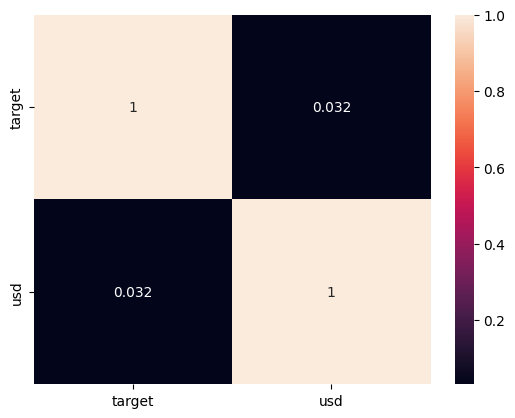

In [26]:
sns.heatmap(train[['target', 'usd']].corr(), annot=True)

In [24]:
np.log1p(1)

0.6931471805599453

In [23]:
np.log(1)

0.0

In [27]:
train['log_target'] = np.log1p(train['target'])

In [28]:
train

,inn_id,week,target,date,usd,log_target
0,inn1000051,0,4.221593e+05,2022-07-25,57.3917,12.953140
1,inn1000051,1,1.622887e+03,2022-08-01,61.3101,7.392578
2,inn1000051,2,1.120726e+06,2022-08-08,60.3696,13.929488
3,inn1000051,3,3.949485e+04,2022-08-15,60.8993,10.583951
4,inn1000051,4,4.302633e+05,2022-08-22,59.1321,12.972155
...,...,...,...,...,...,...
5508073,inn999886,101,6.186212e+06,2024-07-01,85.7480,15.637834
5508074,inn999886,102,2.521118e+07,2024-07-08,88.1348,17.042798
5508075,inn999886,103,1.856761e+07,2024-07-15,87.7427,16.736929
5508076,inn999886,104,2.476758e+07,2024-07-22,88.0206,17.025046


In [29]:
ds = agts.TimeSeriesDataFrame(train[['inn_id', 'date', 'log_target']], id_column='inn_id', timestamp_column='date')

In [32]:
predictor = agts.TimeSeriesPredictor(target='log_target', freq='W', eval_metric='rmse', prediction_length=12).fit(ds, presets='best')

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training...
AutoGluon will save models to '/home/xbar19/ML/AutogluonModels/ag-20250217_203028'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Nov 5 00:21:55 UTC 2024
CPU Count:          16
GPU Count:          1
Memory Avail:       12.08 GB / 15.34 GB (78.7%)
Disk Space Avail:   865.94 GB / 1006.85 GB (86.0%)
Setting presets to: best

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'W-SUN',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'log_target',
 'verbosity': 2}

train_data with frequency 'W-MON' has been resampled to 

In [33]:
preds = predictor.predict(ds)

data with frequency 'W-MON' has been resampled to frequency 'W-SUN'.
/home/xbar19/ML/MLEnv/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [33]:
preds = predictor.predict(ds)

data with frequency 'W-MON' has been resampled to frequency 'W-SUN'.
/home/xbar19/ML/MLEnv/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [34]:
preds

mean        0.1        0.2        0.3        0.4  \
item_id    timestamp                                                           
inn1000051 2024-08-11  12.378271   6.481743   8.673000  10.087150  11.341513   
           2024-08-18  12.432630   5.453359   8.096678   9.793353  11.109220   
           2024-08-25  12.385429   4.490957   7.550111   9.464191  11.013208   
           2024-09-01  12.647717   4.248063   7.388689   9.403458  11.035720   
           2024-09-08  12.520297   3.893908   7.088146   9.257140  10.960322   
...                          ...        ...        ...        ...        ...   
inn999886  2024-09-29  16.654628  15.024094  15.612889  16.010798  16.334716   
           2024-10-06  16.625219  14.906051  15.538901  15.948380  16.300071   
           2024-10-13  16.656543  14.931732  15.546129  15.955115  16.304252   
           2024-10-20  16.689491  14.890522  15.529720  15.976468  16.341270   
           2024-10-27  16.679364  14.846514  15.487157  15.936682  16.306167   

                             0.5        0.6        0.7        0.8        0.9  
item_id    timestamp                                                          
inn1000051 2024-08-11  12.428797  13.504362  14.556597  15.750972  17.461795  
           2024-08-18  12.264770  13.491236  14.699259  16.096972  17.945392  
           2024-08-25  12.340884  13.600720  14.985308  16.549349  18.713985  
           2024-09-01  12.481972  13.954844  15.421205  17.074569  19.447879  
           2024-09-08  12.478783  13.951511  15.558108  17.489120  20.034908  
...                          ...        ...        ...        ...        ...  
inn999886  2024-09-29  16.645872  16.955140  17.271712  17.654951  18.163531  
           2024-10-06  16.630972  16.942509  17.280094  17.668339  18.217484  
           2024-10-13  16.639605  16.967930  17.307142  17.725641  18.273485  
           2024-10-20  16.680236  17.018652  17.373226  17.812398  18.364835  
           2024-10-27  16.648878  17.003495  17.382365  17.813497  18.396040  

[623556 rows x 10 columns]

In [51]:
preds

mean        0.1        0.2        0.3        0.4  \
item_id    timestamp                                                           
inn1000051 2024-08-11  12.158366   6.382571   8.565621   9.933779  11.129579   
           2024-08-18  12.201894   5.413959   8.016661   9.636010  10.897388   
           2024-08-25  12.214134   4.566985   7.572119   9.388918  10.862115   
           2024-09-01  12.487688   4.437455   7.491489   9.382423  10.920846   
           2024-09-08  12.367082   4.045893   7.189357   9.236234  10.849376   
...                          ...        ...        ...        ...        ...   
inn999886  2024-09-29  16.625883  15.141021  15.665069  16.027749  16.327761   
           2024-10-06  16.619835  15.049525  15.618537  15.992660  16.320211   
           2024-10-13  16.643917  15.072596  15.617199  15.991200  16.314379   
           2024-10-20  16.673043  15.033356  15.604579  16.011639  16.349542   
           2024-10-27  16.668764  15.015668  15.576819  15.983576  16.322095   

                             0.5        0.6        0.7        0.8        0.9  
item_id    timestamp                                                          
inn1000051 2024-08-11  12.207081  13.270930  14.314280  15.459970  17.204600  
           2024-08-18  12.040055  13.243564  14.448900  15.783648  17.640130  
           2024-08-25  12.171186  13.404356  14.770548  16.284492  18.426570  
           2024-09-01  12.327888  13.759671  15.179382  16.773324  19.101940  
           2024-09-08  12.327057  13.748686  15.321392  17.161072  19.646634  
...                          ...        ...        ...        ...        ...  
inn999886  2024-09-29  16.617442  16.902499  17.202064  17.560906  18.037453  
           2024-10-06  16.625383  16.912689  17.227762  17.587972  18.099153  
           2024-10-13  16.627587  16.929799  17.246839  17.636550  18.146838  
           2024-10-20  16.664120  16.975910  17.304807  17.709965  18.221999  
           2024-10-27  16.639373  16.962827  17.312746  17.710719  18.253656  

[623556 rows x 10 columns]

In [35]:
calendar

,date,week,part
0,2022-07-25,0,train
1,2022-07-26,0,train
2,2022-07-27,0,train
3,2022-07-28,0,train
4,2022-07-29,0,train
...,...,...,...
821,2024-10-23,117,private
822,2024-10-24,117,private
823,2024-10-25,117,private
824,2024-10-26,117,private


In [52]:
preds = preds.reset_index()

In [53]:
preds = preds.rename(columns={'timestamp': 'date', 'item_id': 'inn_id'})

In [58]:
calendar = pd.read_csv('4cast/calendar.csv')
calendar

,date,week,part
0,2022-07-25,0,train
1,2022-07-26,0,train
2,2022-07-27,0,train
3,2022-07-28,0,train
4,2022-07-29,0,train
...,...,...,...
821,2024-10-23,117,private
822,2024-10-24,117,private
823,2024-10-25,117,private
824,2024-10-26,117,private


In [59]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [60]:
preds = preds.merge(calendar[['date', 'week']], on='date', how='left')
preds

,inn_id,date,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,week
0,inn1000051,2024-08-11,12.158366,6.382571,8.565621,9.933779,11.129579,12.207081,13.270930,14.314280,15.459970,17.204600,106
1,inn1000051,2024-08-18,12.201894,5.413959,8.016661,9.636010,10.897388,12.040055,13.243564,14.448900,15.783648,17.640130,107
2,inn1000051,2024-08-25,12.214134,4.566985,7.572119,9.388918,10.862115,12.171186,13.404356,14.770548,16.284492,18.426570,108
3,inn1000051,2024-09-01,12.487688,4.437455,7.491489,9.382423,10.920846,12.327888,13.759671,15.179382,16.773324,19.101940,109
4,inn1000051,2024-09-08,12.367082,4.045893,7.189357,9.236234,10.849376,12.327057,13.748686,15.321392,17.161072,19.646634,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623551,inn999886,2024-09-29,16.625883,15.141021,15.665069,16.027749,16.327761,16.617442,16.902499,17.202064,17.560906,18.037453,113
623552,inn999886,2024-10-06,16.619835,15.049525,15.618537,15.992660,16.320211,16.625383,16.912689,17.227762,17.587972,18.099153,114
623553,inn999886,2024-10-13,16.643917,15.072596,15.617199,15.991200,16.314379,16.627587,16.929799,17.246839,17.636550,18.146838,115
623554,inn999886,2024-10-20,16.673043,15.033356,15.604579,16.011639,16.349542,16.664120,16.975910,17.304807,17.709965,18.221999,116


In [61]:
preds['week'].value_counts()

week
106    51963
107    51963
108    51963
109    51963
110    51963
111    51963
112    51963
113    51963
114    51963
115    51963
116    51963
117    51963
Name: count, dtype: int64

In [47]:
preds

,inn_id,date,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,week
0,inn1000051,2024-08-11,12.378271,6.481743,8.673000,10.087150,11.341513,12.428797,13.504362,14.556597,15.750972,17.461795,106
1,inn1000051,2024-08-18,12.432630,5.453359,8.096678,9.793353,11.109220,12.264770,13.491236,14.699259,16.096972,17.945392,107
2,inn1000051,2024-08-25,12.385429,4.490957,7.550111,9.464191,11.013208,12.340884,13.600720,14.985308,16.549349,18.713985,108
3,inn1000051,2024-09-01,12.647717,4.248063,7.388689,9.403458,11.035720,12.481972,13.954844,15.421205,17.074569,19.447879,109
4,inn1000051,2024-09-08,12.520297,3.893908,7.088146,9.257140,10.960322,12.478783,13.951511,15.558108,17.489120,20.034908,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623551,inn999886,2024-09-29,16.654628,15.024094,15.612889,16.010798,16.334716,16.645872,16.955140,17.271712,17.654951,18.163531,113
623552,inn999886,2024-10-06,16.625219,14.906051,15.538901,15.948380,16.300071,16.630972,16.942509,17.280094,17.668339,18.217484,114
623553,inn999886,2024-10-13,16.656543,14.931732,15.546129,15.955115,16.304252,16.639605,16.967930,17.307142,17.725641,18.273485,115
623554,inn999886,2024-10-20,16.689491,14.890522,15.529720,15.976468,16.341270,16.680236,17.018652,17.373226,17.812398,18.364835,116


In [48]:
sub

,inn_id,week,predict
0,inn1000051,106,7.430786e+06
1,inn1000051,107,7.430786e+06
2,inn1000051,108,7.430786e+06
3,inn1000051,109,7.430786e+06
4,inn1000051,110,7.430786e+06
...,...,...,...
623551,inn999886,113,1.977608e+07
623552,inn999886,114,1.977608e+07
623553,inn999886,115,1.977608e+07
623554,inn999886,116,1.977608e+07


In [62]:
sub1 = sub.copy()
sub1 = sub1.merge(preds[['inn_id', 'week', 'mean']], on=['inn_id', 'week'], how='left')

In [63]:
sub1['mean'] = np.expm1(sub1['mean'])

In [64]:
sub1

,inn_id,week,predict,mean
0,inn1000051,106,7.430786e+06,1.906817e+05
1,inn1000051,107,7.430786e+06,1.991651e+05
2,inn1000051,108,7.430786e+06,2.016177e+05
3,inn1000051,109,7.430786e+06,2.650526e+05
4,inn1000051,110,7.430786e+06,2.349382e+05
...,...,...,...,...
623551,inn999886,113,1.977608e+07,1.661611e+07
623552,inn999886,114,1.977608e+07,1.651592e+07
623553,inn999886,115,1.977608e+07,1.691848e+07
623554,inn999886,116,1.977608e+07,1.741848e+07


In [53]:
from sklearn.metrics import root_mean_squared_log_error

root_mean_squared_log_error(sub1['predict'], sub1['mean'].clip(lower=0))

1.9046784023410486

In [65]:
sub['predict'] = sub1['mean'].clip(lower=0).values.copy()

In [66]:
sub.to_csv('4cast/submissions/sub1.csv', index=False)